In [1]:
# import libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

import time

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
df_cleaned = pd.read_csv('data/listings_cleaned.csv', low_memory=False)
df_cleaned.head()

,id,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,...,number_of_reviews,availability_365,review_scores_rating,instant_bookable,is_business_travel_ready,cancellation_policy,host_is_superhost,listing_url,region,price_per_person
0,2265,30.27750,-97.71398,House,Entire home/apt,4,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,24,0,93.0,f,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/2265,East,56.250000
1,5245,30.27577,-97.71379,House,Private room,2,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,9,0,91.0,f,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/5245,East,50.000000
2,5456,30.26112,-97.73448,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",...,529,334,97.0,f,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/5456,East,31.666667
3,5769,30.45697,-97.78422,House,Private room,2,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,257,14,98.0,f,f,moderate,t,https://www.airbnb.com/rooms/5769,North,20.000000
4,6413,30.24829,-97.73726,Guesthouse,Entire home/apt,2,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",...,112,0,99.0,t,f,strict_14_with_grace_period,t,https://www.airbnb.com/rooms/6413,South,49.500000


In [3]:
features_list = ['property_type', 'room_type', 'bathrooms', 'bedrooms', 'host_is_superhost',  'region', 'accommodates',
                 'review_scores_rating', 'number_of_reviews', 'extra_people', 'security_deposit', 'cleaning_fee']

# Create features and price DFs for sklearn inputs
df_cleaned = df_cleaned[df_cleaned.price < df_cleaned.price.quantile(.95)]
features = df_cleaned[features_list]   # 'X'
y = df_cleaned['price']           # 'y'
y.describe()

count    11026.000000
mean       197.029657
std        178.504356
min         16.000000
25%         80.000000
50%        129.000000
75%        250.000000
max        990.000000
Name: price, dtype: float64

In [4]:
log_y = np.log(y)
print(log_y.head(), y.head())
log_y.describe()

0    5.416100
1    4.605170
2    4.553877
3    3.688879
4    4.595120
Name: price, dtype: float64 0    225.0
1    100.0
2     95.0
3     40.0
4     99.0
Name: price, dtype: float64


count    11026.000000
mean         4.941971
std          0.824734
min          2.772589
25%          4.382027
50%          4.859812
75%          5.521461
max          6.897705
Name: price, dtype: float64

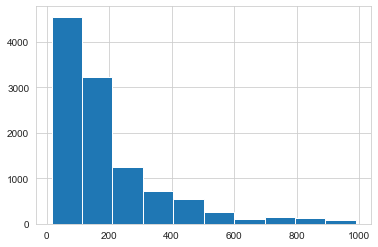

In [5]:
y.hist()

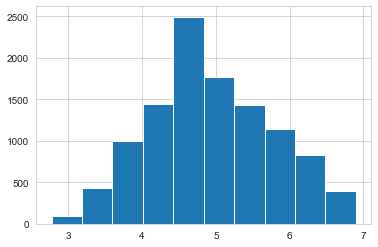

In [6]:
log_y.hist()

In [7]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features, drop_first=True)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,extra_people,security_deposit,cleaning_fee,property_type_Apartment,property_type_Bed and breakfast,...,property_type_Townhouse,property_type_Villa,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_t,region_East,region_North,region_South,region_West
0,2.0,2.0,4,93.0,24,30.0,500.0,100.0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,1.0,1.0,2,91.0,9,35.0,500.0,75.0,0,0,...,0,0,0,1,0,1,1,0,0,0
2,1.0,1.0,3,97.0,529,45.0,100.0,0.0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1.0,1.0,2,98.0,257,0.0,0.0,0.0,0,0,...,0,0,0,1,0,1,0,1,0,0
4,1.0,1.0,2,99.0,112,25.0,0.0,50.0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [8]:
from sklearn.decomposition import PCA

# Set up PCA and the X vector for diminsionality reduction
pca = PCA()
df_X = features[['bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating', 'number_of_reviews',
                'extra_people', 'security_deposit', 'cleaning_fee']]

# Apply PCA to the wine dataset X vector
transformed_X = pca.fit_transform(df_X)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

[9.52622869e-01 2.23268862e-02 2.17897912e-02 3.02338339e-03
 1.99077142e-04 3.51823734e-05 2.05051981e-06 7.60327308e-07]


In [9]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'accommodates','review_scores_rating', 'number_of_reviews',
            'extra_people', 'security_deposit', 'cleaning_fee']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [10]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,extra_people,security_deposit,cleaning_fee,property_type_Apartment,property_type_Bed and breakfast,...,property_type_Townhouse,property_type_Villa,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_t,region_East,region_North,region_South,region_West
0,0.230769,0.125,0.200000,0.9125,0.025343,0.100000,0.098039,0.153846,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0.076923,0.000,0.066667,0.8875,0.009504,0.116667,0.098039,0.115385,0,0,...,0,0,0,1,0,1,1,0,0,0
2,0.076923,0.000,0.133333,0.9625,0.558606,0.150000,0.019608,0.000000,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0.076923,0.000,0.066667,0.9750,0.271383,0.000000,0.000000,0.000000,0,0,...,0,0,0,1,0,1,0,1,0,0
4,0.076923,0.000,0.066667,0.9875,0.118268,0.083333,0.000000,0.076923,0,0,...,0,0,0,0,0,1,0,0,1,0


In [11]:
#features_scaled.to_csv('data/listings_scaled.csv')

### Modeling:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    log_y, 
                                                    test_size = .25, 
                                                    random_state = 42)
                                                    #stratify=log_y)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

Training set has 8269 samples.
Test set has 2757 samples.


In [13]:
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 10),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=500, random_state=42)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
print(results)

{'SVR': 0.49352762401445494, 'DecisionTreeRegressor': 0.5177594481234729, 'LinearRegression': 0.5052409227280363, 'KNeighborsRegressor': 0.4944806274132957, 'RandomForestRegressor': 0.5820452079376796}


In [14]:
# Training Decision Tree Classifier Model
modelDTR = DecisionTreeRegressor()

modelDTR.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [15]:
X_test

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,extra_people,security_deposit,cleaning_fee,property_type_Apartment,property_type_Bed and breakfast,...,property_type_Townhouse,property_type_Villa,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_t,region_East,region_North,region_South,region_West
7907,0.076923,0.000,0.200000,0.9875,0.022175,0.016667,0.078431,0.132308,1,0,...,0,0,0,0,0,0,1,0,0,0
967,0.076923,0.000,0.066667,0.8125,0.004224,0.166667,0.000000,0.046154,0,0,...,0,0,0,1,0,0,0,0,1,0
3695,0.153846,0.125,0.466667,1.0000,0.017951,0.083333,0.019608,0.023077,0,0,...,1,0,0,0,0,0,1,0,0,0
8430,0.230769,0.250,0.333333,0.9875,0.015839,0.000000,0.058824,0.230769,0,0,...,0,0,0,0,0,1,0,0,1,0
9835,0.076923,0.000,0.200000,0.9750,0.012672,0.000000,0.000000,0.023077,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10153,0.153846,0.125,0.333333,0.7250,0.008448,0.166667,0.098039,0.192308,0,0,...,0,0,0,0,0,0,0,0,0,0
5923,0.076923,0.125,0.133333,0.9625,0.033791,0.033333,0.049020,0.038462,0,0,...,0,0,0,0,0,1,1,0,0,0
1367,0.153846,0.000,0.200000,0.7500,0.001056,0.000000,0.019608,0.030769,0,0,...,0,0,0,1,0,0,0,0,1,0
6308,0.153846,0.125,0.333333,0.9625,0.032735,0.063333,0.039216,0.121538,0,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
y_test

7907     4.787492
967      4.653960
3695     4.605170
8430     5.616771
9835     4.317488
           ...   
10153    5.433722
5923     4.317488
1367     4.605170
6308     4.859812
626      4.077537
Name: price, Length: 2757, dtype: float64

In [17]:
modelDTR.score(X_test, y_test)

0.27382446640192626

In [18]:
# Accuracy score for Decision Tree
y_pred = modelDTR.predict(X_test)
cross_val_score(modelDTR, features_scaled, y, cv=10)
#print('Decision Tree Regressor accuracy: {:.2f}'.format()))

array([ 0.15751071,  0.10802941,  0.05762904,  0.13728465, -0.07268201,
        0.03956662,  0.09859095, -0.01396736, -0.12856975, -0.41503079])

In [19]:
# Using GridSearchCV on DecisionTreeClassifier
#create a dictionary of all values we want to test
param_dist = {"max_depth": np.arange(1, 21),
              #"max_features": randint(1, 9),
              "min_samples_leaf": [1, 5, 10, 20, 50, 100],
              #"criterion": ["gini", "entropy"]
             }
#use gridsearch to test all values
dtr_cv = GridSearchCV(modelDTR, param_dist, cv=5)
#fit model to data
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                     

In [20]:
print(dtr_cv.best_params_)
print(cross_val_score(modelDTR, features_scaled, y, cv=10))

{'max_depth': 9, 'min_samples_leaf': 10}
[ 1.52220577e-01  1.19026589e-01  8.98343223e-02  1.51518648e-01
 -6.70747163e-02 -1.81635593e-04  8.00064823e-02 -4.18415189e-02
 -1.04445388e-01 -3.34495290e-01]


In [21]:
modelDTR = DecisionTreeRegressor(max_depth= 9, min_samples_leaf= 10)
modelDTR.fit(X_train, y_train)
y_test_preds = modelDTR.predict(X_test)
print(y_test_preds)
r2_score(y_test, y_test_preds)

[4.82936861 4.04810255 5.43551562 ... 4.04810255 5.08273512 4.04810255]


0.5177594481234729

In [22]:
knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
knn_mse = mean_squared_error(predictions, y_test)
knn_mse

0.35661421446425595

In [23]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [24]:
xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   45.7s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_chi

In [28]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [27]:
print("Best Params XGB MSE:", round(mean_squared_error(y_test, xgb_grid.predict(X_test)),4))
print("Best Params XGB r2:", round(r2_score(y_test, xgb_grid.predict(X_test)),4))

Best Params XGB MSE: 0.2707
Best Params XGB r2: 0.6089


In [32]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.03,
 max_depth= 5,
 min_child_weight= 4,
 n_estimators= 500,
 nthread= 4,
 objective= 'reg:linear',
 silent= 1,
 subsample= 0.7)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 0.2047
Validation MSE: 0.2707

Training r2: 0.6971
Validation r2: 0.6089


SVR Model: 0.49352762401445494
DecisionTreeRegressor Model: 0.5177594481234729
LinearRegression Model: 0.5052409227280363
KNeighborsRegressor Model: 0.4944806274132957
RandomForestRegressor Model: 0.5820452079376796


Text(0.5, 1.0, 'Comparison of Regression Models')

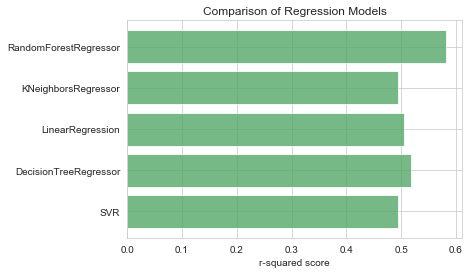

In [33]:
for model, result in results.items():
    #print(model, result)
    print('{} Model: {}'.format(model, result))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [38]:
# models with hyperparameter tuning

models = [SVR(kernel='linear'),
          modelDTR,
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=500, random_state=42),
          xgb_reg]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
print(results)

{'SVR': 0.49352762401445494, 'DecisionTreeRegressor': 0.5177594481234729, 'LinearRegression': 0.5052409227280363, 'KNeighborsRegressor': 0.4944806274132957, 'RandomForestRegressor': 0.5820452079376796, 'XGBRegressor': 0.6089359458211341}


SVR Model: 0.49352762401445494
DecisionTreeRegressor Model: 0.5177594481234729
LinearRegression Model: 0.5052409227280363
KNeighborsRegressor Model: 0.4944806274132957
RandomForestRegressor Model: 0.5820452079376796
XGBRegressor Model: 0.6089359458211341


Text(0.5, 1.0, 'Comparison of Regression Models')

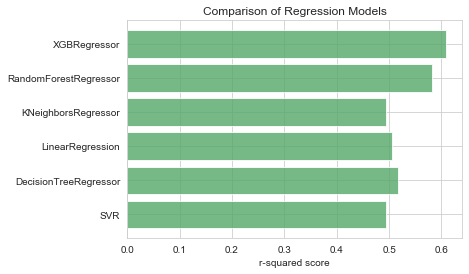

In [39]:
for model, result in results.items():
    #print(model, result)
    print('{} Model: {}'.format(model, result))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')